In [12]:
import numpy as np
import scipy.integrate as spi

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 16

From the previous notebook (PC1), we reuse the code that simulates the activity of two neuronal populations that receive each a noisy input. 
We will study the variability of the measure across simulations.

## Comparing stimulations

### Exercise

- copy the code from the PC1 notebook and run several simulations with an increased number of regions (`n_node = 4`); recall to adjust the coupling matrix J
- plot the histograms for each element of the covariance matrix for two classes
- from the scikit-learn library, look at the principal component analysis (PCA) to reduce the dimensionality https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html, check the example https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html
- use the PCA analysis to compare the variability of the observed covariance matrix across the two classes
- reuse the PCA analysis corresponding to the number of samples `n` in the previous notebook (which we can rename as duration time `T`)

Let's get the code from the previous notebook to simulate the OU process.

In [8]:
def ou(dt, J, u, x_ini):
    '''
    arguments:
        dt: time step
        J: coupling matrix (Jacobian)
            ndarray of shape (n,n)
        u: input
            ndarray of shape (t,n)
        x_ini: initial condition
            ndarray of shape (n)
    return:
        vt: trace for time
        vx: trace for x
    '''
    J = np.asarray(J)
    u = np.asarray(u)
    # get network size n via J and simulation duration t via I
    n_node = J.shape[0]
    n_time = u.shape[0]
    # optional checks
    assert J.shape[0] == J.shape[1], """J should be a square matrix"""
    assert u.shape[1] == J.shape[0], """u should be a matrix with same second dimension as J"""
    
    # initial conditions for variables x (vector)
    x = np.copy(x_ini)
    # traces for time and x; loop over time stamps
    ts = np.zeros([n_time])
    tx = np.zeros_like(u)
    for it in range(n_time):
        # update traces
        ts[it] = it * dt
        tx[it,:] = x
        # update variables x
        x += dt * np.dot(J, x) + (dt**0.5) * u[it,:]
    # return traces
    return ts, tx

In [81]:
T = 10 # simulation duration
dt = 0.1 # time step for simulation
n_node = 4 # node number

n_sample = 100 # sample number

# X = matrix of features, y = vector of labels
X = np.zeros([n_sample,n_node,n_node])
y = np.zeros([n_sample])

for i_sample in range(n_sample):
    # labels y for 2 classes depending on Jacobian J
    if i_sample<n_sample/2:
        J = -np.eye(n_node)
        J[0,1] = J[1,2] = 0.5 # positive weight for coupling from node 1 to node 0
        y[i_sample] = 0
    else:
        J = -np.eye(n_node)
        J[0,1] = J[1,2] = -0.5 # negative weight for coupling from node 1 to node 0
        y[i_sample] = 1
    # random initial condition
    x_ini = np.random.randn(n_node)
    # random input
    u = np.random.randn(int(T/dt)+1,n_node)
    # run simulation
    ts, tx = ou(dt, J, u, x_ini)
    # calculate covariance on simulated activity, store the cross-covariance
    cov = np.cov(tx, rowvar=False)
    X[i_sample,:,:] = cov

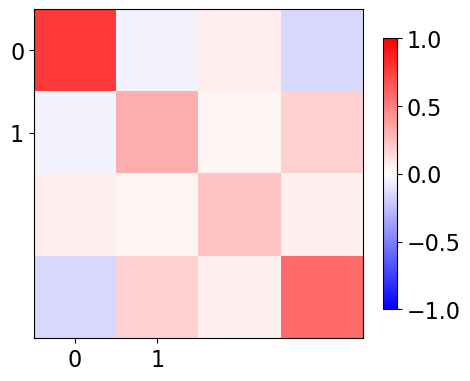

In [83]:
# example covariance matrix: it's symmetric!!!
plt.figure(figsize=(5,5))
plt.imshow(X[0,:,:], vmin=-1.0, vmax=1.0, cmap='bwr')
plt.colorbar(shrink=0.6)
plt.xticks(range(2))
plt.yticks(range(2))
plt.tight_layout()

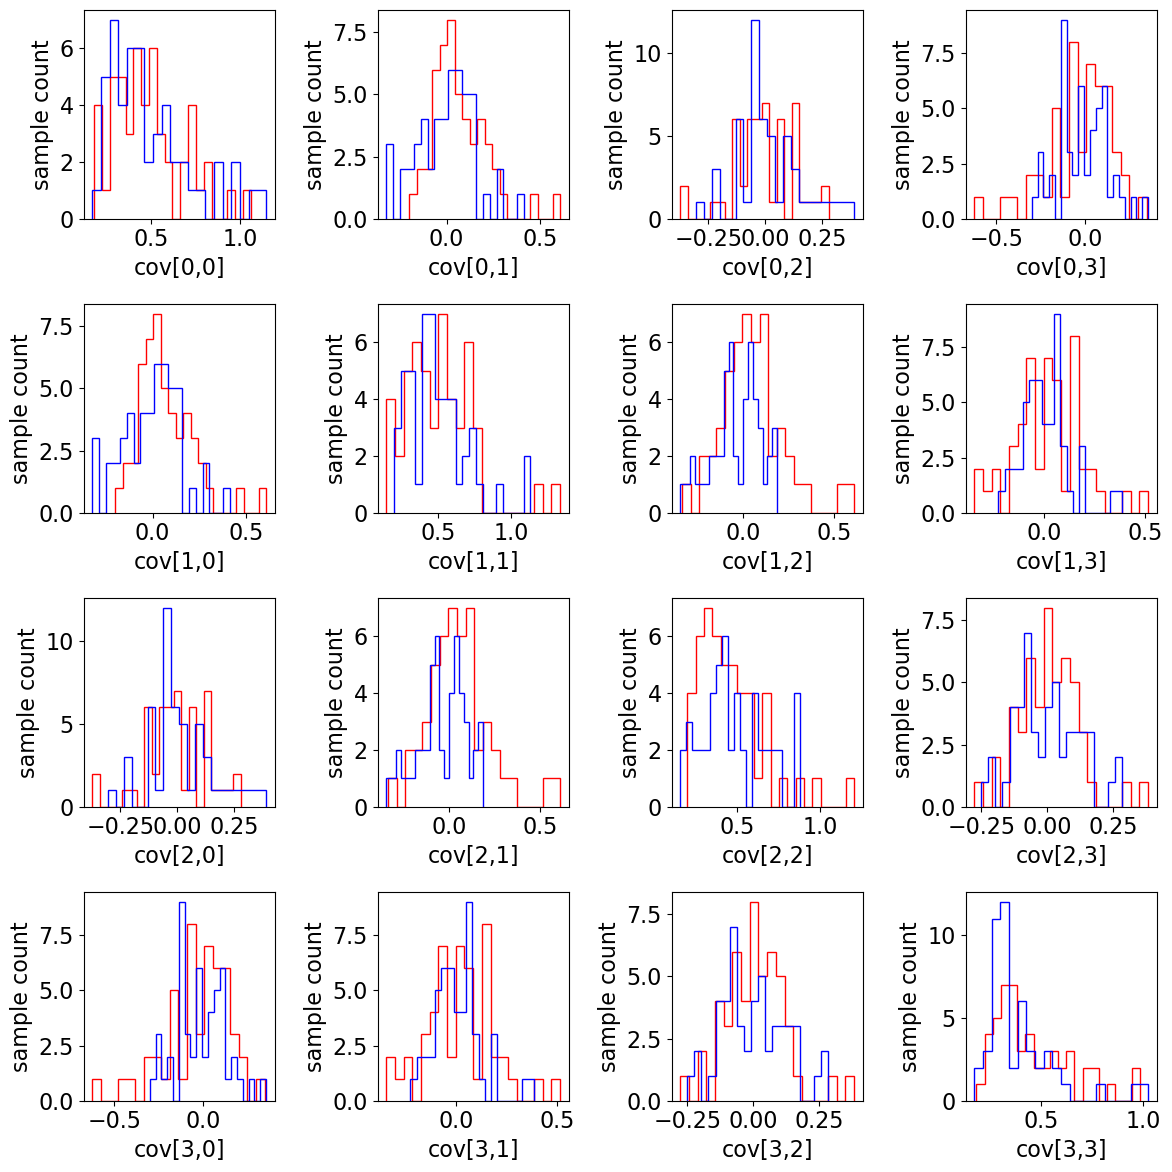

In [89]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
for i in range(n_node): # there are 10 non-symmetric elements in the covariance matrix
    for j in range(n_node): # there are 10 non-symmetric elements in the covariance matrix
        ax = axs[i,j]
        ax.hist(X[y==0,i,j], color='r', bins=20, histtype='step')
        ax.hist(X[y==1,i,j], color='b', bins=20, histtype='step')
        ax.set_xlabel(f'cov[{i},{j}]')
        ax.set_ylabel('sample count')
fig.tight_layout()

We see that the covariance is a symmetric matrix. We can take only the upper triangle, corresponding to independent elements. Let's consider a squared matrix like the covariance matrix, then extract specific elements from the matrix.

In [26]:
A = np.arange(4*4).reshape([4,4])
print(A)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [59]:
print(A.flatten())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [28]:
# check individual elements
i = 1
j = 3
print(f'A[{i},{j}] = {A[i,j]}')

A[1,3] = 7


In [34]:
# get indices corresponding to upper triangle
np.triu_indices_from(A)

(array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3]), array([0, 1, 2, 3, 1, 2, 3, 2, 3, 3]))

In [36]:
# print elements from upper triangle
A[np.triu_indices_from(A)]

array([ 0,  1,  2,  3,  5,  6,  7, 10, 11, 15])

We can adjust the previous code to focus on the 10 elements of the upper triangle of the covariance matrix.

In [120]:
T = 10 # simulation duration
dt = 0.1 # time step for simulation
n_node = 4 # node number

n_sample = 100 # sample number

# indices to extract elements from covariance matrix
i_ind, j_ind = np.triu_indices(4)

# X = matrix of features, y = vector of labels
X = np.zeros([n_sample,i_ind.size])
y = np.zeros([n_sample])

for i_sample in range(n_sample):
    # labels y for 2 classes depending on Jacobian J
    if i_sample<n_sample/2:
        J = -np.eye(n_node)
        J[0,1] = J[1,2] = 0.5 # positive weight for coupling from node 1 to node 0
        y[i_sample] = 0
    else:
        J = -np.eye(n_node)
        J[0,1] = J[1,2] = -0.5 # negative weight for coupling from node 1 to node 0
        y[i_sample] = 1
    # random initial condition
    x_ini = np.random.randn(n_node)
    # random input
    u = np.random.randn(int(T/dt)+1,n_node)
    # run simulation
    ts, tx = ou(dt, J, u, x_ini)
    # calculate covariance on simulated activity, store the cross-covariance
    cov = np.cov(tx, rowvar=False)
    X[i_sample,:] = cov[i_ind, j_ind]

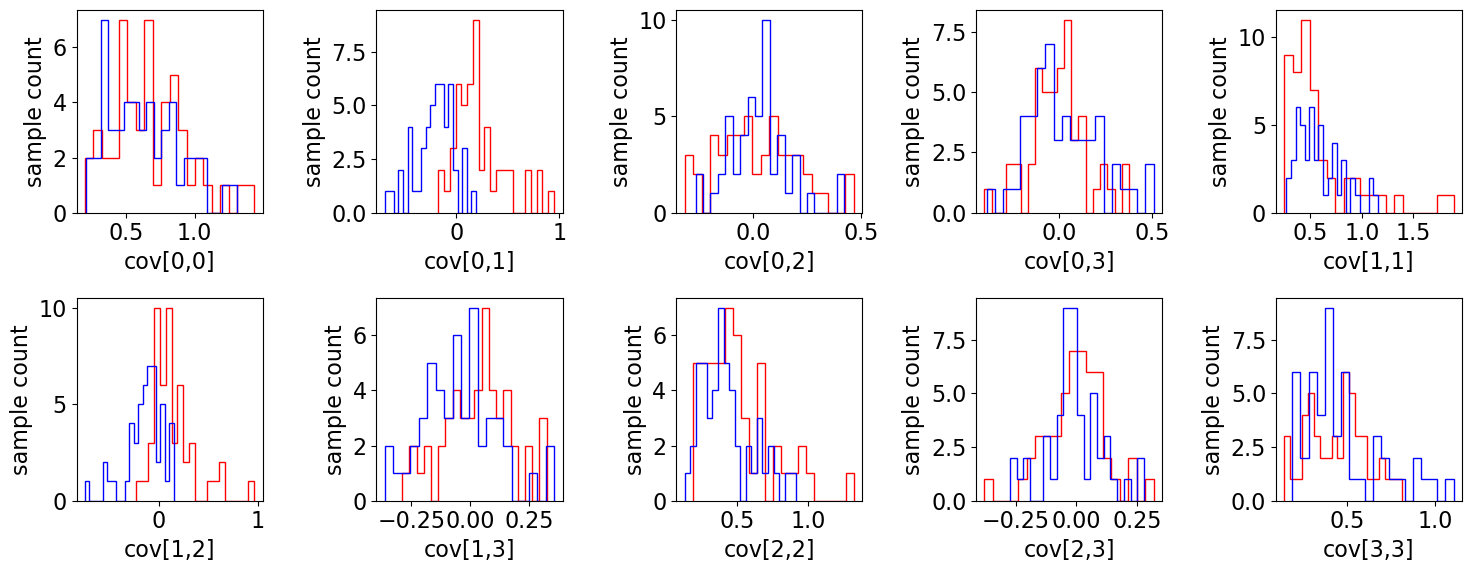

In [124]:
fig, axs = plt.subplots(2,5,figsize=(15,6))
for i in range(10): # there are 10 non-symmetric elements in the covariance matrix
    ax = axs[i//5,i%5]
    ax.hist(X[y==0,i], color='r', bins=20, histtype='step')
    ax.hist(X[y==1,i], color='b', bins=20, histtype='step')
    ax.set_xlabel(f'cov[{i_ind[i]},{j_ind[i]}]')
    ax.set_ylabel('sample count')
fig.tight_layout()